In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import Span
from shapely.geometry import Point
import geopandas as gpd
import glob
from datetime import datetime
from bokeh.layouts import Row, column, gridplot
from bokeh.models import Title, Legend, TapTool, Range1d, Tabs, TabPanel
import matplotlib as mpl
output_notebook()
from bokeh.core.validation import silence
from bokeh.core.validation.warnings import MISSING_RENDERERS, EMPTY_LAYOUT

# Set fonts for matplotlib
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14

Loading BokehJS ...

In [234]:
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(EMPTY_LAYOUT, True)

{Warning(code=1000, name='MISSING_RENDERERS', description='Plot has no renderers'),
 Warning(code=1002, name='EMPTY_LAYOUT', description='Layout has no children')}

In [2]:
def convert_to_gdf(df):
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

# Analysing business activity trends in Turkiye

[Business Activity Trends](https://dataforgood.facebook.com/dfg/tools/business-activity-trends#methodology) are a crisis-triggered dataset released by Meta. The dataset is relesed at a GADM admin 2 level. [GADM shpefiles](https://gadm.org/) are slightly different from the official shapefiles used in this project from [HdX, UNOCHA](https://data.humdata.org/dataset/cod-ab-tur). Two Business Activity Trends datasets are used in this analysis - COVID-19 triggered dataset and Turkiye Earthquake triggered dataset. 

This notebook shows the implementation of 

* Visualizing a baseline of Business Activity one year prior to the earthquake (February 2022)
* Visualizing changes in trends in Business Actviity after the earthquake by admin region and business vertical

In [3]:
turkey_adm2 = gpd.read_file('../../data/turkey_administrativelevels0_1_2/tur_polbna_adm2.shp')
turkey_adm1 = gpd.read_file('../../data/turkey_administrativelevels0_1_2/tur_polbnda_adm1.shp')

## Observing Business Activity Trends 

The Business Activity from two datasets is obtained to compare this year's chnge in activity to last year - COVID-19 triggered dataset (2022) and erthquake triggered datset (2023).

### Earthquake triggered business activity dataset

The Earthquake triggered Business Activity Trends dataset contains daily data from 5th Februaary, 2023 likely till May 2023. This is done at the [GADM 2](https://gadm.org/) level. The activity quantile metric is used to measure changes in Business Activity. 

**Activity quantile (activity_quantile)**: The level of activity as a quantile relative to the baseline period. This is equivalent to the 7-day average of what the University of Bristol researchers call the aggregated probability integral transform metric (see this article in Nature Communications). It’s calculated by first computing the approximate quantiles (the midquantiles in the article) of each Page’s daily activity relative to their baseline activity. The quantiles are summed and the sum is then shifted, rescaled and variance-adjusted to follow a standard normal distribution. The adjusted sum is then probability transformed through a standard normal cumulative distribution function to get a value between 0 and 1. We then average this value over the last 7 days to smooth out daily fluctuations. We give this metric a quantile interpretation since it compares the daily activity to the distribution of daily activity within the baseline period, where a value around 0.5 is considered normal activity. This is a one-vote-per-Page metric that gives equal weight to all businesses and is not heavily influenced by businesses that post a lot. It is adviced to use this metric, especially if robustness to outliers and numerical stability are important concerns.

### COVID-19 triggered business activity dataset

The COVID-19 triggered Business Activity Trends dataset contains daily data from March 1, 2020 to Nov 29, 2022 at the national level. Activity quantile is used to measure the business activity trends in this dataset as well. 


#### Difference between COVID-19 Business Activity Trends dataset and the Earthquake triggered Business Activity trends dataset

The difference between then **All** Business Vertical in the COVID-19 Business Activity Trends dataset and the Earthquake triggered Business Activity trends dataset is that the latter does not include Public Good. The rest of the business activities remain the same across the two datasets (detaled descriptions in the previous page). Another difference is that the baseline value earthquake triggered dataset is a 90 day prior value. For the COVID-19 Business Activity Trends it is 1st March, 2019.




In [4]:
all_files = glob.glob('../../data/business_activity_trend/raw/2022_February/*.csv')

businessActivity2022 = pd.DataFrame(columns = ['polygon_id', 'polygon_name', 'polygon_level', 'polygon_version',
       'country', 'business_vertical', 'activity_quantile', 'latitude',
       'longitude', 'ds'])

li = []

for file in all_files:
    df1 = pd.read_csv(file)
    li.append(df1)

businessActivity2022 = pd.concat(li, axis=0)
businessActivity2022 = businessActivity2022[businessActivity2022['country']=='TR']

In [5]:
# convert columns to datetime
businessActivity2022['ds'] = businessActivity2022['ds'].apply(lambda x: pd.to_datetime(x))
businessActivity2022 = businessActivity2022[businessActivity2022['country']=='TR' ]

In [6]:
business_verticals = list(businessActivity2022['business_vertical'].unique())

print(f'COVID-19 Business Actvity Trends has the following business verticals {business_verticals}')

COVID-19 Business Actvity Trends has the following business verticals ['Business & Utility Services', 'Travel', 'Local Events', 'Lifestyle Services', 'Public Good', 'Manufacturing', 'Grocery & Convenience Stores', 'Professional Services', 'Home Services', 'Retail', 'All', 'Restaurants']


In [16]:
# define color palette
color_palette = [  '#4E79A7',  # Blue
    '#F28E2B',  # Orange
    '#E15759',  # Red
    '#76B7B2',  # Teal
    '#59A14F',  # Green
    '#EDC948',  # Yellow
    '#B07AA1',  # Purple
    '#FF9DA7',  # Pink
    '#9C755F',  # Brown
    '#BAB0AC',  # Gray
    '#7C7C7C',  # Dark gray
    '#6B4C9A',  # Violet
    '#D55E00',  # Orange-red
    '#CC61B0',  # Magenta
    '#0072B2',  # Bright blue
    '#329262',  # Peacock green
    '#9E5B5A',  # Brick red
    '#636363',  # Medium gray
    '#CD9C00',  # Gold
    '#5D69B1',  # Medium blue
]

In [228]:
bokeh.core.validation.silence(EMPTY_LAYOUT, True)

def get_line_plot(businessActivity,title, source, earthquakes=False, subtitle=None):

    p2 = figure(x_axis_type = 'datetime', width = 800, height = 400, toolbar_location='above')
    p2.add_layout(Legend(), "right")

    for id, business_vertical in enumerate(businessActivity['business_vertical'].unique()):
        df = businessActivity[businessActivity['business_vertical']==business_vertical][['ds', 'activity_quantile']].reset_index(drop=True)
        p2.line(df['ds'], df['activity_quantile'], line_width=2, line_color = color_palette[id], legend_label=business_vertical)

    p2.legend.click_policy='hide'
    if subtitle is not None:
        p2.title = subtitle


    title_fig = figure(title=title, toolbar_location=None,width=800, height=40, )
    title_fig.title.align = "left"
    title_fig.title.text_font_size = "20pt"
    title_fig.border_fill_alpha = 0
    title_fig.outline_line_width=0

    #with silence(MISSING_RENDERERS):
    sub_title = figure(title=source, toolbar_location=None,width=800, height=40, )
    sub_title.title.align = "left"
    sub_title.title.text_font_size = "10pt"
    sub_title.title.text_font_style="normal"
    sub_title.border_fill_alpha = 0
    sub_title.outline_line_width=0

    layout = column(title_fig, p2, sub_title)

    if earthquakes:
        p2.renderers.extend([
        Span(
            location=datetime(2023, 2, 6),
            dimension="height",
            line_color='#7C7C7C',
            line_width=2,
            line_dash=(4,4)
      ),
        Span(
            location=datetime(2023, 2, 20),
            dimension="height",
            line_color='#7C7C7C',
            line_width=2,
            line_dash=(4,4)
        ),
    ]
)

    return layout



In [8]:
# Get all datasets for earthquake-triggered business activity trends
all_files = glob.glob('../../data/business_activity_trend/raw/*.csv')

businessActivity2023 = pd.DataFrame(columns = ['polygon_id', 'polygon_name', 'polygon_level', 'polygon_version',
       'country', 'business_vertical', 'activity_quantile', 'latitude',
       'longitude', 'ds'])

li = []

for file in all_files:
    df1 = pd.read_csv(file)
    li.append(df1)

businessActivity2023 = pd.concat(li, axis=0)

In [9]:
# convert columns to datetime
businessActivity2023['ds'] = businessActivity2023['ds'].apply(lambda x: pd.to_datetime(x))
businessActivity2023 = businessActivity2023[businessActivity2023['country']=='TR' ]

In [11]:
print(f'Business Activity Trends has {len(businessActivity2023["polygon_name"].unique())} districts and the boundaries map from UNOCHA contains {len(turkey_adm2["adm2_en"].unique())} districts. {len(turkey_adm2["adm2_en"].unique())-len(businessActivity2023["polygon_name"].unique())} districts do not have data')

Business Activity Trends has 575 districts and the boundaries map from UNOCHA contains 948 districts. 373 districts do not have data


In [12]:
# Convert polygon name to upper to match with boundaries file and change column name
import unicodedata

businessActivity2023['polygon_name'] = businessActivity2023['polygon_name'].apply(lambda x: x.upper())
businessActivity2023['polygon_name'] = businessActivity2023['polygon_name'].apply(lambda x: unicodedata.normalize('NFD', x).encode('ascii', 'ignore').decode('utf-8'))

# Fixing the business activity trends admin names to match UNOCHA
businessActivity2023['polygon_name'].replace({'EYUP':'EYUPSULTAN', 'ONDOKUZ MAYIS':'19 MAYIS','KAZAN':'KAHRAMANKAZAN',
                          'DOGUBEYAZIT': 'DOGUBAYAZIT', 'MUSTAFA KEMALPASA':'MUSTAFAKEMALPASA', 'SULTAN KOCHISAR':'SEREFLIKOCHISAR',
                            'SINCANLI':'SINANPASA', 'AKKOY':'PAMUKKALE', 'SULTAN KARAHISAR':'SEBINKARAHISAR' }, inplace = True)

matched_districts = list(set(businessActivity2023['polygon_name'].unique()).intersection(set(turkey_adm2['adm2_en'].unique())))
print(list(businessActivity2023[~(businessActivity2023["polygon_name"].isin(matched_districts))]['polygon_name'].unique()))
print('The above districts remain unmapped. Note: Merkez district unmapped is due to a bug in the GADM data. To account for this, we used the lat long coordinates and joined with the shapefiles being used in this project from UNOCHA')

['MERKEZ']
The above districts remain unmapped. Note: Merkez district unmapped is due to a bug in the GADM data. To account for this, we used the lat long coordinates and joined with the shapefiles being used in this project from UNOCHA


In [67]:
gdf = convert_to_gdf(businessActivity2023)
gdf = turkey_adm2.sjoin(gdf)[[ 'adm2_en', 'adm1_en', 'adm1', 'pcode', 'geometry',
       'business_vertical', 'activity_quantile', 'ds']]
gdf = gdf.sort_values(by='ds')

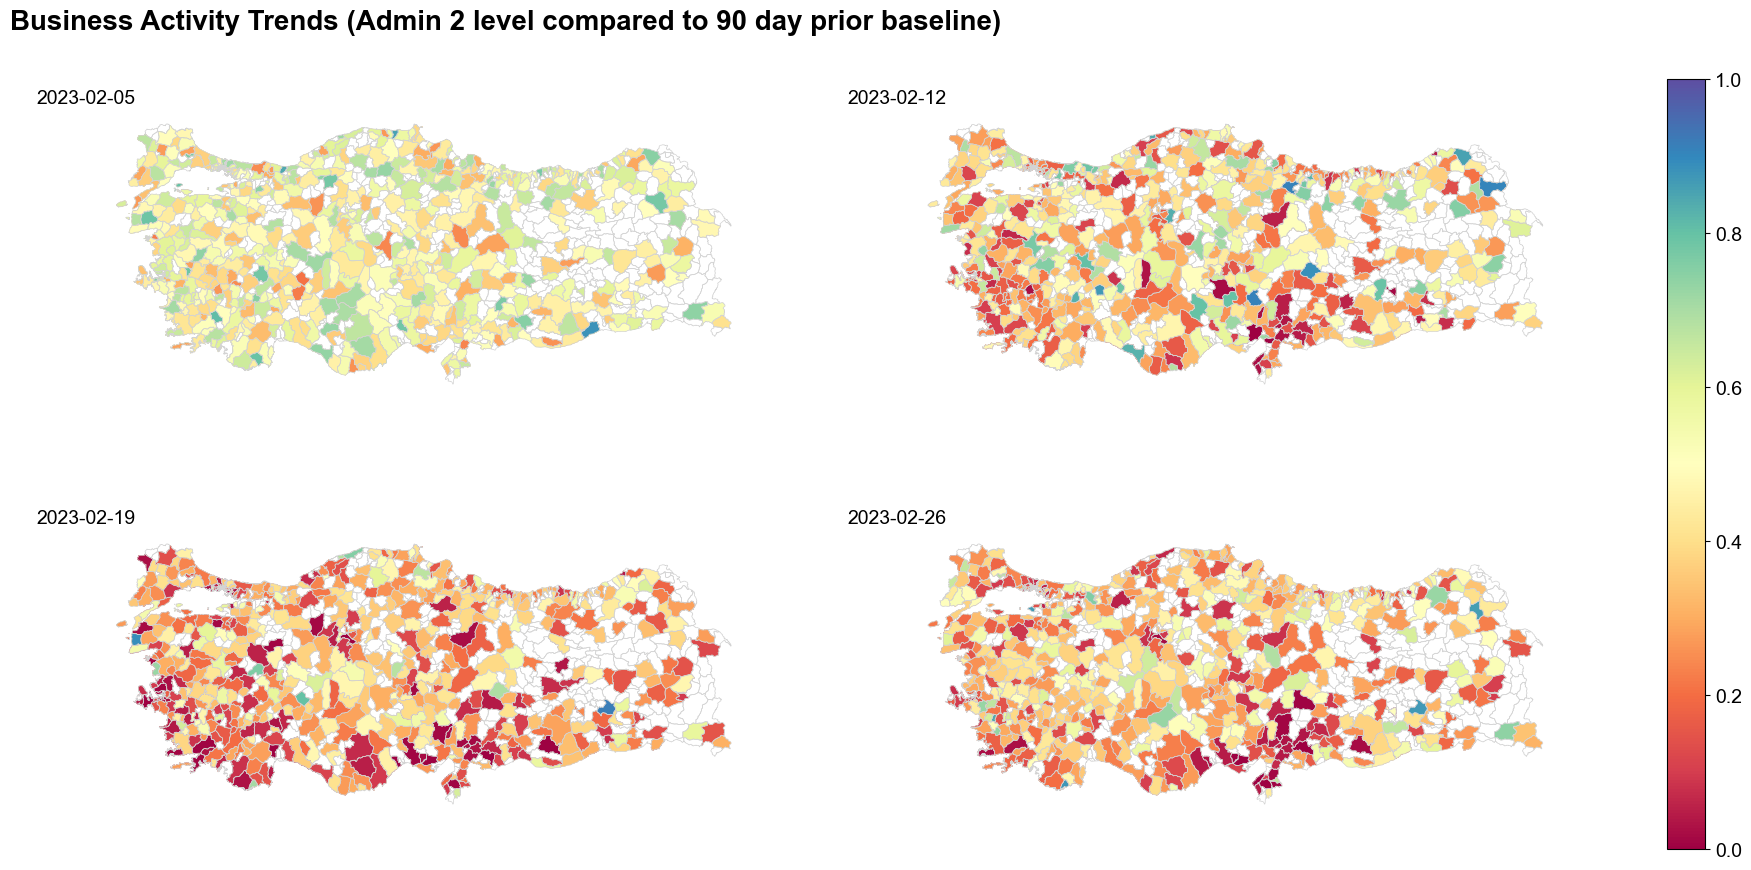

In [68]:
fig, axs = plt.subplots(2,2,figsize = (24,10), sharex=True, sharey=True)
ax = axs.flatten()


dates_of_interest = ['2023-02-05', '2023-02-12', '2023-02-19', '2023-02-26']
images = []

for i in range(0, len(dates_of_interest)):
    turkey_adm2.boundary.plot(ax=ax[i], edgecolor = '#D3D3D3', linewidth=0.5)
    im=gdf[gdf['ds']==dates_of_interest[i]][['activity_quantile', 'geometry']].plot(column = 'activity_quantile', ax=ax[i], legend = False, cmap = 'Spectral', vmin=0, vmax =1)
    images.append(im.collections[0])
    ax[i].set_title(f'{dates_of_interest[i]}', fontsize = 14, )
    ax[i].title.set_position([0,0])

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

cbar = fig.colorbar(images[1], ax=axs)
suptitle= fig.suptitle('Business Activity Trends (Admin 2 level compared to 90 day prior baseline)', fontsize = 20, fontweight = 'bold')
suptitle.set_y(0.95)
suptitle.set_x(0.3)
#ax[0].cax = cbar.ax[0]

for im in images:
    im.set_clim(vmin=0, vmax=1)
    im.set_cmap('Spectral')
    im.set_norm(cbar.norm)

In [231]:
tabs = []

# Taking the mean activity quantile for the entire country to allow for comparison with last year's data
df = businessActivity2023.groupby(['country', 'business_vertical', 'ds']).mean('activity_quantile')[['activity_quantile']].reset_index()

tabs.append(
    TabPanel(
    child=get_line_plot(df, f"Business Activity in 2023", "Source: Data for Good Meta", earthquakes=True, subtitle = 'National average post earthquake compared to 90 day prior baseline'),
                title='2023',
            )
            )

tabs.append(
    TabPanel(
    child=get_line_plot(businessActivity2022, f"Business Activity in 2022 (National average post COVID-19)", "Source: Data for Good Meta", subtitle = 'National average post COVID-19 compared to pre-pandemic baseline'),
                title='2022',
            )
            )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

## Change in Business Activity by business verticals in affected areas

Although national average may be useful to compare with baseline data available at the same level from 2022, for the sake of understanding earthquake impact, it might be useful to see the impact of the earthquake on business verticals in the affected regions. For this we get the data for the areas of interest within Turkey,and see how business activity changed in those regions. 

We show the data here in two formats - 
1. Daily changes in Business Activity
2. Weekly changes in Business Activity where the data is aggregated at a week level

In [48]:
aoi = gpd.read_file('../../data/SYRTUR_tessellation.geojson')
aoi = gdf[gdf['pcode'].isin(aoi['ADM2_PCODE'].unique())]

In [81]:
nr_adm = len(aoi['pcode'].unique())
#affected_adm2 = list(aoi['pcode'].unique())
affected_adm2 = list(turkey_adm2[turkey_adm2['pcode'].isin(aoi['pcode'].unique())]['adm2_en'])
print(f'There are {nr_adm} admin-2 regions which are of interest')

There are 75 admin-2 regions which are of interest


In [108]:
# Obtain admin areas of interest using multiple ways
# 1. Get the areas with the highest earthquake intensity
earthquake_intensity = pd.read_csv('../../data/turkiye_earthquke_intensity_adm2.csv')
earthquake_intensity.drop(columns = 'Unnamed: 0', inplace = True)
affected_adm2 = list(earthquake_intensity.sort_values(by='mean_of_mean_intensity_feb06', ascending = False).head(7)['adm2_en'])

# 2. Get limited areas manually from the list of earthquake impacted areas
affected_adm2 = ['NURDAGI', 'ISLAHIYE', 'DEFNE', 'ANTAKYA', 'KUMLU', 'SEHITKAMIL', 'HASSA']

In [19]:
gdf['business_vertical'].fillna('Unknown', inplace = True)

In [76]:
business_verticals = ['Public Good', 'Retail', 'Grocery & Convenience Stores',
       'Professional Services', 'Restaurants', 'Manufacturing',
       'Business & Utility Services', 'Lifestyle Services', 'Home Services', 'Travel', 'Local Events', 'All']

#### Get week level data

In [53]:
# #convert date column to datetime and subtract one week
# gdf['date'] = pd.to_datetime(gdf['ds']) - pd.to_timedelta(7, unit='d')

#calculate sum of values, grouped by week
week = gdf.groupby([pd.Grouper(key='ds', freq='W-MON'), 'adm2_en', 'adm1_en', 'adm1', 'pcode', 'business_vertical']).mean('activity_quantile')[['activity_quantile']].reset_index()

In [232]:
tabs = []

for adm in most_affected_adm2:
    df = gdf[gdf['adm2_en']==adm] 

    tabs.append(
        TabPanel(
        child=get_line_plot(df, f"Business Activity in Affected Areas", "Source: Data for Good Meta", earthquakes=True, subtitle = 'GADM2 level average post earthquake compared to 90 day prior baseline'),
                    title=adm.capitalize(),
                )
                )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

In [233]:
tabs = []

for adm in most_affected_adm2:
    df = week[week['adm2_en']==adm] 

    tabs.append(
        TabPanel(
        child=get_line_plot(df, f"Weekly Business Activity in Affected Areas", "Source: Data for Good Meta", earthquakes=True, subtitle = 'GADM2 level average post earthquake compared to 90 day prior baseline'),
                    title=adm.capitalize(),
                )
                )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

### Writing processed files to csv for interested dates and sectors

In this case, we write files for 5th february (pre earthquke), 6th february (immediately after the earthquake) and for weekly averages post earthquake

In [98]:
#p = gdf.groupby(['adm2_en', 'ds']).mean().reset_index()
df = pd.DataFrame()

for business_vertical in ['Retail', 'Manufacturing', 'All']:

    p = gdf.groupby(['adm2_en', 'ds', 'business_vertical']).mean().reset_index()

    for date in ['2023-02-05', '2023-02-06']:
            
        df = p[p['ds']==date][['ds','adm2_en', 'activity_quantile', 'business_vertical']].merge(turkey_adm2[['adm2_en', 'adm1_en']],on='adm2_en', how = 'right').reset_index(drop=True)
        df['ds'] = date
        df['business_vertical'] = business_vertical
        df.rename(columns = {'ds':'date'}, inplace = True)
        df = pd.concat([df, df.sort_values(by='adm2_en')])#.to_csv(f'../data/network_coverage/final/business_activity_trends_{date}.csv')

    p['date'] = pd.to_datetime(p['ds']) - pd.to_timedelta(7, unit='d')

    #calculate sum of values, grouped by week
    week = p.groupby([pd.Grouper(key='date', freq='W-MON'), 'adm2_en', 'business_vertical']).mean().reset_index()

    for date in ['2023-02-13', '2023-02-20', '2023-02-27', '2023-03-06']:
        
        df = week[week['date']==date][['date','adm2_en', 'activity_quantile', 'business_vertical']].merge(turkey_adm2[['adm2_en', 'adm1_en']],on='adm2_en', how = 'right').reset_index(drop=True)
        df['date'] = date
        df['business_vertical'] = business_vertical
        df = pd.concat([df,df1.sort_values(by='adm2_en')])#.to_csv(f'../data/network_coverage/final/business_activity_trends_{date}.csv')
    
# combning all files into a single file
df = df.fillna(-100)
df = df.pivot_table(index=['adm1_en', 'adm2_en','business_vertical'], values='activity_quantile',columns='date').reset_index().sort_values(by=['business_vertical', 'adm2_en']).reset_index(drop=True)
df.replace(-100,np.nan, inplace = True)

df.to_csv('../data/business_activity_trend/final/business_activity_trends_indicators.csv')